# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

     |████████████████████████████████| 83 kB 1.4 MB/s 
     |████████████████████████████████| 462 kB 26.9 MB/s 
  Created wheel for adapt: filename=adapt-0.4.1-py3-none-any.whl size=105169 sha256=4c8dbf56cb6080d017b6d1ced8224ce5bd77f9bf65710d77ca410a5ecfba4f4a
  Stored in directory: /root/.cache/pip/wheels/84/70/4b/23d24c3b067b3ab9c051d3ac1a63ba632b6ca6a45b633ace7e
Successfully built adapt


In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_128_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_128_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_128_train3.pkl"
Source_dir_train4 = "./Images/DANN/Source/LC25000_mix_data_128_train4.pkl"
Source_dir_train5 = "./Images/DANN/Source/LC25000_mix_data_128_train5.pkl"
Source_dir_test1 = "./Images/DANN/Source/LC25000_mix_data_128_test1.pkl"
Source_dir_test2 = "./Images/DANN/Source/LC25000_mix_data_128_test2.pkl"


Target_dir_train = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_train.pkl")
Target_dir_test = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_test.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_train.pkl")
Target_cyclegan_dir_test = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_test.pkl")

In [ ]:
BATCH_SIZE = 64
CHANNELS = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCH = 5

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)
with open(os.path.abspath(Source_dir_train4), "rb") as f:
    LC25000_train4 = pickle.load(f)
with open(os.path.abspath(Source_dir_train5), "rb") as f:
    LC25000_train5 = pickle.load(f)
with open(os.path.abspath(Source_dir_test1), "rb") as f:
    LC25000_test1 = pickle.load(f)
with open(os.path.abspath(Source_dir_test2), "rb") as f:
    LC25000_test2 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] + LC25000_train4['train'] + LC25000_train5['train']
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label'],LC25000_train4['train_label'],LC25000_train5['train_label']))
LC25000_test_data = LC25000_test1['test'] + LC25000_test2['test']
LC25000_test_labels = np.concatenate((LC25000_test1['test_label'],LC25000_test2['test_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)
LC25000_test_lab = tf.one_hot(LC25000_test_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)
LC25000_test_data_au = data_augmentation(LC25000_test_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)
LC25000_test_data_au = np.array(LC25000_test_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)
print("The shape of LC25000_test_data: ", LC25000_test_data_au.shape)
print("The shape of LC25000_test_labels: " ,LC25000_test_labels.shape)

The shape of LC25000_train_data:  (6400, 128, 128, 3)
The shape of LC25000_train_labels:  (6400,)
The shape of LC25000_test_data:  (1600, 128, 128, 3)
The shape of LC25000_test_labels:  (1600,)


In [ ]:
import gc
gc.collect()

122

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train), "rb") as f:
    TCGA_train = pickle.load(f)
with open(os.path.abspath(Target_dir_test), "rb") as f:
    TCGA_test = pickle.load(f)

In [ ]:
TCGA_train_data = TCGA_train['train']
TCGA_train_labels = TCGA_train['train_label']
TCGA_test_data = TCGA_test['test']
TCGA_test_labels = TCGA_test['test_label']

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (6400, 128, 128, 3)
The shape of TCGA_train_labels:  (6400,)
The shape of TCGA_test_data:  (6400, 128, 128, 3)
The shape of TCGA_test_labels:  (6400,)


In [ ]:
import gc
gc.collect()

200

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


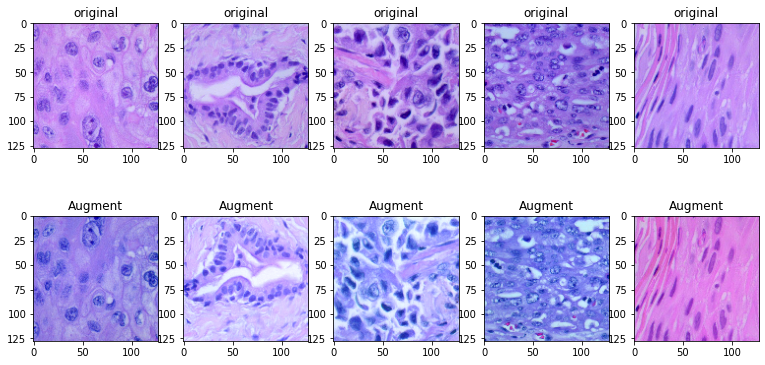

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(13, 13))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

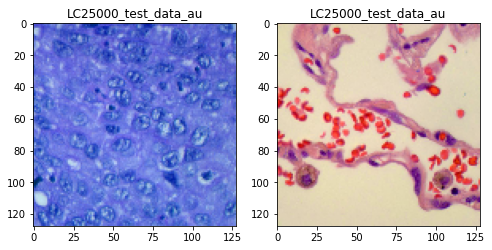

In [ ]:
# random show images
plt.subplots(1,2,figsize=(8,8))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_test_data_au)
img1 = array_to_img(sample1)
plt.title("LC25000_test_data_au")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_test_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_test_data_au")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

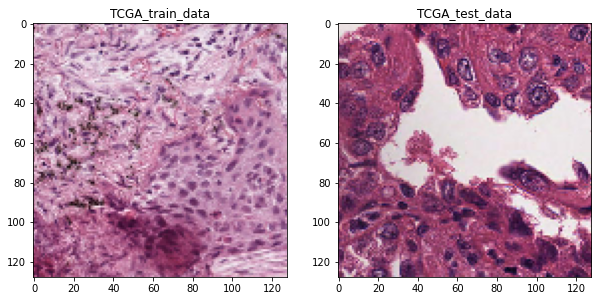

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_test_data")
plt.imshow(img2)
plt.show

In [ ]:
#LC25000_train_data, LC25000_train_labels, TCGA_train_data, TCGA_train_labels

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_128.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_128.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 4, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))


print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data_au (source) shape: (6400, 128, 128, 3)
TCGA_train_data (target) shape: (6400, 128, 128, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=250, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 5s 22ms/step - loss: 1.0831 - acc: 0.4208 - val_loss: 1.1072 - val_acc: 0.3787
Epoch 2/5
100/100 [==============================] - 2s 18ms/step - loss: 0.9697 - acc: 0.6345 - val_loss: 1.1094 - val_acc: 0.4295
Epoch 3/5
100/100 [==============================] - 2s 18ms/step - loss: 0.8603 - acc: 0.6795 - val_loss: 1.1146 - val_acc: 0.4341
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.7559 - acc: 0.7217 - val_loss: 1.1191 - val_acc: 0.4364
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.6653 - acc: 0.7506 - val_loss: 1.1250 - val_acc: 0.4397
Epoch 1/250
100/100 [==============================] - 5s 28ms/step - loss: 0.5876 - acc: 0.7789 - val_loss: 1.1372 - val_acc: 0.4467
Epoch 2/250
100/100 [==============================] - 2s 22ms/step - loss: 0.5227 - acc: 0.7987 - val_loss: 1.1601 - val_acc: 0.4512
Epoch 3/250
100/100 [==============================] - 2s 22ms/step - lo

### Run 2

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=200, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 22ms/step - loss: 1.0884 - acc: 0.3953 - val_loss: 1.0875 - val_acc: 0.4430
Epoch 2/5
100/100 [==============================] - 2s 18ms/step - loss: 0.9791 - acc: 0.5755 - val_loss: 1.1081 - val_acc: 0.3958
Epoch 3/5
100/100 [==============================] - 2s 18ms/step - loss: 0.8719 - acc: 0.6523 - val_loss: 1.1275 - val_acc: 0.3731
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.7646 - acc: 0.6922 - val_loss: 1.1365 - val_acc: 0.3830
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.6718 - acc: 0.7286 - val_loss: 1.1385 - val_acc: 0.3983
Epoch 1/200
100/100 [==============================] - 4s 28ms/step - loss: 0.5904 - acc: 0.7650 - val_loss: 1.1527 - val_acc: 0.4111
Epoch 2/200
100/100 [==============================] - 2s 22ms/step - loss: 0.5224 - acc: 0.7934 - val_loss: 1.1687 - val_acc: 0.4295
Epoch 3/200
100/100 [==============================] - 2s 22ms/step - lo

### Run 3

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=250, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 23ms/step - loss: 1.0796 - acc: 0.4531 - val_loss: 1.1417 - val_acc: 0.2402
Epoch 2/5
100/100 [==============================] - 2s 18ms/step - loss: 0.9759 - acc: 0.5750 - val_loss: 1.1534 - val_acc: 0.3231
Epoch 3/5
100/100 [==============================] - 2s 18ms/step - loss: 0.8794 - acc: 0.6269 - val_loss: 1.1616 - val_acc: 0.3509
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.7783 - acc: 0.6775 - val_loss: 1.1642 - val_acc: 0.3731
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.6869 - acc: 0.7206 - val_loss: 1.1701 - val_acc: 0.3875
Epoch 1/250
100/100 [==============================] - 4s 28ms/step - loss: 0.6071 - acc: 0.7484 - val_loss: 1.1785 - val_acc: 0.4064
Epoch 2/250
100/100 [==============================] - 2s 24ms/step - loss: 0.5384 - acc: 0.7830 - val_loss: 1.1914 - val_acc: 0.4250
Epoch 3/250
100/100 [==============================] - 3s 26ms/step - lo

### Run 4

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=250, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 4s 25ms/step - loss: 1.0997 - acc: 0.4106 - val_loss: 1.1564 - val_acc: 0.0886
Epoch 2/5
100/100 [==============================] - 2s 21ms/step - loss: 0.9702 - acc: 0.5886 - val_loss: 1.1428 - val_acc: 0.2792
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.8597 - acc: 0.6373 - val_loss: 1.1387 - val_acc: 0.3508
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.7556 - acc: 0.6789 - val_loss: 1.1358 - val_acc: 0.3833
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.6637 - acc: 0.7184 - val_loss: 1.1407 - val_acc: 0.4013
Epoch 1/250
100/100 [==============================] - 5s 30ms/step - loss: 0.5886 - acc: 0.7561 - val_loss: 1.1434 - val_acc: 0.4217
Epoch 2/250
100/100 [==============================] - 2s 23ms/step - loss: 0.5212 - acc: 0.7862 - val_loss: 1.1586 - val_acc: 0.4378
Epoch 3/250
100/100 [==============================] - 2s 23ms/step - lo

### Run 5

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=250, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 24ms/step - loss: 1.1187 - acc: 0.3603 - val_loss: 1.1395 - val_acc: 0.3059
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.9929 - acc: 0.5502 - val_loss: 1.1386 - val_acc: 0.3925
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.8772 - acc: 0.6261 - val_loss: 1.1414 - val_acc: 0.4097
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.7686 - acc: 0.6859 - val_loss: 1.1416 - val_acc: 0.4211
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.6747 - acc: 0.7295 - val_loss: 1.1448 - val_acc: 0.4369
Epoch 1/250
100/100 [==============================] - 4s 29ms/step - loss: 0.5927 - acc: 0.7658 - val_loss: 1.1570 - val_acc: 0.4436
Epoch 2/250
100/100 [==============================] - 2s 24ms/step - loss: 0.5240 - acc: 0.7917 - val_loss: 1.1766 - val_acc: 0.4522
Epoch 3/250
100/100 [==============================] - 2s 24ms/step - lo

### Result

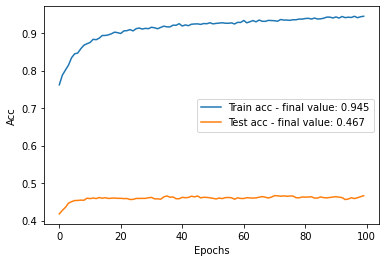

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


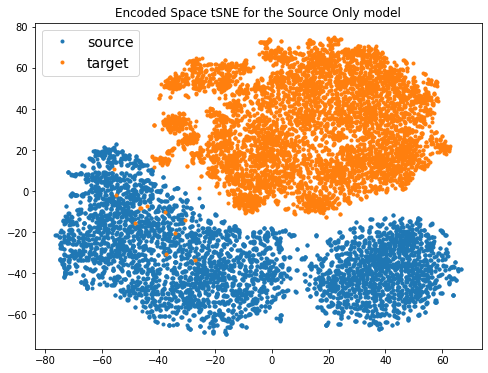

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = finetunig.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.207350,0.914495,1.814655,0.459662
std,0.083875,0.034218,0.221819,0.006742
min,0.134356,0.762031,1.158929,0.417969
25%,0.157506,0.910273,1.738859,0.459023
50%,0.179023,0.925234,1.871254,0.460781
75%,0.220086,0.934883,1.952930,0.462539
max,0.592561,0.944844,2.119607,0.466719


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_source_Resnet_128_RMS_0.5e-6_AU.csv")

# Fit with adaptation

In [ ]:
# shuffle the data (not necessary)
# np.random.seed(0)
# shuffle_src = np.random.choice(len(LC25000_train_data_au_ex), len(LC25000_train_data_au_ex), replace=False)
# shuffle_tgt = np.random.choice(len(TCGA_train_data_ex), len(TCGA_train_data_ex), replace=False)

# LC25000_train_data_au_ex = LC25000_train_data_au_ex[shuffle_src]
# LC25000_train_lab = LC25000_train_lab[shuffle_src]
# TCGA_train_data_ex = TCGA_train_data_ex[shuffle_tgt]
# TCGA_train_lab = TCGA_train_lab[shuffle_tgt]


### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 42ms/step - loss: 0.1220 - acc: 0.9513 - disc_loss: 2.3457 - val_loss: 2.1868 - val_acc: 0.4728
Epoch 2/200
100/100 [==============================] - 4s 36ms/step - loss: 0.1242 - acc: 0.9483 - disc_loss: 2.1847 - val_loss: 2.2148 - val_acc: 0.4762
Epoch 3/200
100/100 [==============================] - 4s 36ms/step - loss: 0.1219 - acc: 0.9519 - disc_loss: 2.0737 - val_loss: 2.2483 - val_acc: 0.4769
Epoch 4/200
100/100 [==============================] - 4s 36ms/step - loss: 0.1243 - acc: 0.9498 - disc_loss: 1.9730 - val_loss: 2.2514 - val_acc: 0.4828
Epoch 5/200
100/100 [==============================] - 4s 37ms/step - loss: 0.1167 - acc: 0.9517 - disc_loss: 1.8984 - val_loss: 2.2577 - val_acc: 0.4831
Epoch 6/200
100/100 [==============================] - 4s 36ms/step - loss: 0.1227 - acc: 0.9533 - disc_loss: 1.8307 - val_loss: 2.2877 - val_acc: 0.4864
Epoch 7/200
100/100 [==============================] - 4s 36ms/step - loss: 

### Run 2

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 4s 43ms/step - loss: 0.0939 - acc: 0.9705 - disc_loss: 8.3116 - val_loss: 6.2100 - val_acc: 0.4936
Epoch 2/200
100/100 [==============================] - 4s 38ms/step - loss: 0.0730 - acc: 0.9747 - disc_loss: 8.3571 - val_loss: 6.2688 - val_acc: 0.4916
Epoch 3/200
100/100 [==============================] - 4s 38ms/step - loss: 0.0772 - acc: 0.9734 - disc_loss: 8.2767 - val_loss: 6.9031 - val_acc: 0.4938
Epoch 4/200
100/100 [==============================] - 4s 37ms/step - loss: 0.0803 - acc: 0.9722 - disc_loss: 8.3660 - val_loss: 6.3953 - val_acc: 0.4931
Epoch 5/200
100/100 [==============================] - 4s 39ms/step - loss: 0.0765 - acc: 0.9753 - disc_loss: 8.3831 - val_loss: 6.9090 - val_acc: 0.4933
Epoch 6/200
100/100 [==============================] - 4s 37ms/step - loss: 0.0824 - acc: 0.9739 - disc_loss: 8.3053 - val_loss: 6.2011 - val_acc: 0.4919
Epoch 7/200
100/100 [==============================] - 4s 38ms/step - loss: 

### Run 3

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 4s 39ms/step - loss: 0.0763 - acc: 0.9719 - disc_loss: 1.8285 - val_loss: 17.4090 - val_acc: 0.4903
Epoch 2/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0851 - acc: 0.9709 - disc_loss: 1.8245 - val_loss: 17.2202 - val_acc: 0.4934
Epoch 3/200
100/100 [==============================] - 4s 36ms/step - loss: 0.0814 - acc: 0.9712 - disc_loss: 1.8799 - val_loss: 16.8793 - val_acc: 0.4900
Epoch 4/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0895 - acc: 0.9691 - disc_loss: 1.9091 - val_loss: 16.7728 - val_acc: 0.4905
Epoch 5/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0932 - acc: 0.9692 - disc_loss: 1.8839 - val_loss: 16.9453 - val_acc: 0.4923
Epoch 6/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0867 - acc: 0.9723 - disc_loss: 1.8676 - val_loss: 16.1976 - val_acc: 0.4891
Epoch 7/200
100/100 [==============================] - 4s 35ms/step - 

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

### Run 4

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 4s 39ms/step - loss: 0.1139 - acc: 0.9614 - disc_loss: 6.3615 - val_loss: 35.4980 - val_acc: 0.4986
Epoch 2/200
100/100 [==============================] - 3s 34ms/step - loss: 0.1079 - acc: 0.9625 - disc_loss: 6.2370 - val_loss: 35.5786 - val_acc: 0.4986
Epoch 3/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0981 - acc: 0.9664 - disc_loss: 6.2603 - val_loss: 35.4539 - val_acc: 0.4977
Epoch 4/200
100/100 [==============================] - 3s 34ms/step - loss: 0.0991 - acc: 0.9655 - disc_loss: 6.1752 - val_loss: 35.1979 - val_acc: 0.4986
Epoch 5/200
100/100 [==============================] - 3s 34ms/step - loss: 0.0917 - acc: 0.9672 - disc_loss: 6.1327 - val_loss: 34.9172 - val_acc: 0.4986
Epoch 6/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0989 - acc: 0.9639 - disc_loss: 6.0893 - val_loss: 34.8655 - val_acc: 0.4988
Epoch 7/200
100/100 [==============================] - 3s 34ms/step - 

### Run 5

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 4s 39ms/step - loss: 0.0652 - acc: 0.9737 - disc_loss: 0.3610 - val_loss: 2.8149 - val_acc: 0.4825
Epoch 2/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0627 - acc: 0.9762 - disc_loss: 0.3648 - val_loss: 2.8146 - val_acc: 0.4828
Epoch 3/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0596 - acc: 0.9775 - disc_loss: 0.3616 - val_loss: 2.8363 - val_acc: 0.4833
Epoch 4/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0635 - acc: 0.9762 - disc_loss: 0.3601 - val_loss: 2.8506 - val_acc: 0.4819
Epoch 5/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0619 - acc: 0.9767 - disc_loss: 0.3589 - val_loss: 2.8305 - val_acc: 0.4831
Epoch 6/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0598 - acc: 0.9778 - disc_loss: 0.3600 - val_loss: 2.8368 - val_acc: 0.4837
Epoch 7/200
100/100 [==============================] - 3s 35ms/step - loss: 

### Result

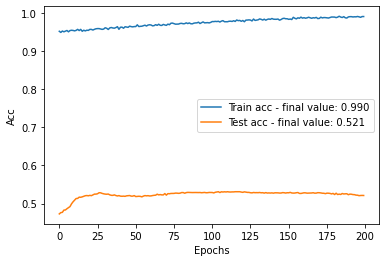

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


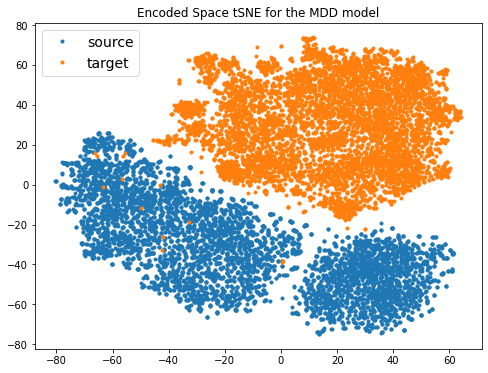

In [ ]:
LC25000_train_data_au_enc = mdd.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.068865,0.973505,0.479258,3.580954,0.523519
std,0.028874,0.011873,0.517308,0.648492,0.009685
min,0.027510,0.948281,0.098097,2.186760,0.472813
25%,0.042833,0.963594,0.192186,3.428211,0.521367
50%,0.063707,0.975625,0.263373,3.528151,0.526797
75%,0.092131,0.984062,0.479578,3.996264,0.528437
max,0.124290,0.990625,3.019947,4.857440,0.530937


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD/MDD_Resnet_RMS_ 0.5e-6_g1_AU.csv")